## Import libraries

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn import preprocessing

## Import Dataset

In [87]:
dataset = pd.read_csv('Data/dogs_intakes_outcomes_clean.csv')

## Setting dependent variable categories

In [88]:
dataset =  dataset.loc[(dataset['outcome_type'] == 'Adoption') | 
                                 (dataset['outcome_type'] == 'Transfer')

                                 | (dataset['outcome_type'] == 'Return to Owner')]
                                 #(dataset['outcome_type'] == 'Euthanasia')

dataset['outcome_subtype'] = np.where(pd.isnull(dataset['outcome_subtype']), 
                                           dataset['outcome_type'], 
                                           dataset['outcome_subtype'])

In [89]:
x = dataset.filter(items=['sex', 'spay/neuter', 'breed', 'coat', 'mixed_breed', 'age_upon_intake_(years)', 
                           'intake_month', 'intake_weekday', 'intake_hour', 'intake_condition', 'intake_type'])

In [90]:
for col in x:
    x[col] = x[col].astype('category')
    
y = dataset['outcome_subtype'].astype('category')

In [91]:
xd = pd.get_dummies(x)
xnames = xd.columns
xarr = np.array(xd)


In [92]:
yarr, ynames = pd.factorize(dataset['outcome_subtype'])

# Split x and y arrays into training and testing sets

In [93]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV

x_train, x_test, y_train, y_test = train_test_split(xarr, yarr, 
                                                    test_size=0.3, random_state=1)

In [94]:
scaler = preprocessing.StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Find most important features with random forest

In [95]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=1000, criterion='entropy', 
                                       class_weight='balanced_subsample', bootstrap=True, oob_score=True)

rf_classifier.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=True,
                       random_state=None, verbose=0, warm_start=False)

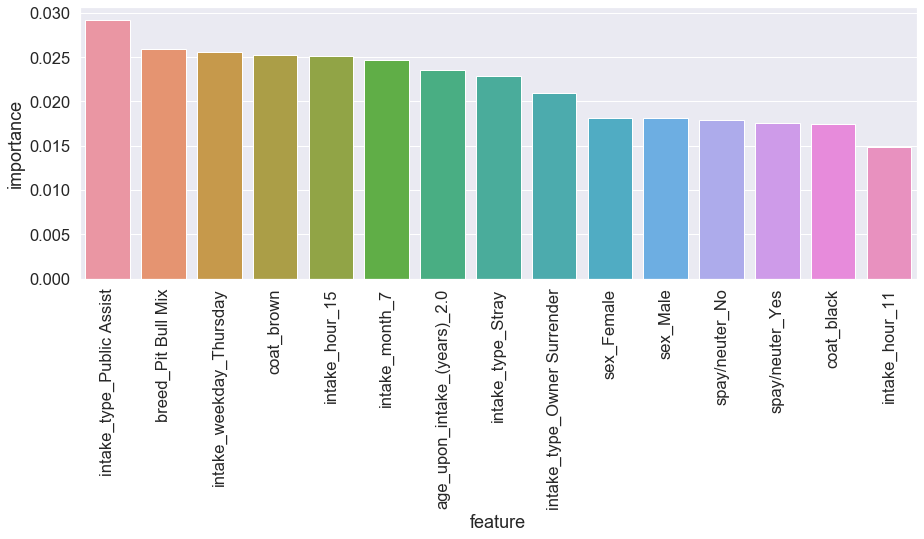

In [96]:
feature_importances = rf_classifier.feature_importances_

importances = pd.DataFrame({'importance': feature_importances, 'feature': xnames}, 
                           index=xnames).sort_values(by='importance', ascending=False)

sns.set(font_scale=1.50)
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
sns.barplot(x='feature', y='importance', data=importances[0:15])

# Use PCA to reduce dimensions

In [97]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(x_train_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [98]:
print(len(pca.components_))

2028


# Chain kbest feature extration to PCA with feature union

In [99]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline, FeatureUnion

feature_union = FeatureUnion([
    ('pca', PCA()),
    ('kbest', SelectKBest())
])

prediction_model = Pipeline([
    ('feature_union', feature_union),
    ('rf', RandomForestClassifier(n_estimators=1000, criterion='entropy', 
                                  class_weight='balanced_subsample', bootstrap=True, 
                                  oob_score=True))
])

In [ ]:
import warnings
warnings.simplefilter('ignore')

prediction_model.fit(x_train_scaled, y_train)

# Test prediction with StratifiedKFold

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

cv = StratifiedKFold(3)
cv_score = cross_val_score(prediction_model, x_train_scaled, y_train, cv=cv, scoring='accuracy')
cv_predict_score = cross_val_predict(prediction_model, x_train_scaled, y_train, cv=cv)

In [ ]:
print(cv_score)
print(np.mean(cv_score))

print(accuracy_score(y_train, cv_predict_score))